In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
import scipy.stats as stats

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['figure.facecolor'] = 'white'

Xdict = {}
Pdict = {}

In [2]:
def phi_in_gaussian(kx, ky, F4, l):
    k = np.sqrt(kx * kx + ky * ky)
    return k * np.exp(-k*k / F4) / ((kx + l*1.0j) * (kx + l*1.0j) - k)

def calculate_wake(F, l=0.002, kmax=64, d=0.03125):
    k = np.arange(-kmax, kmax+d, d)
    n = len(k)
    
    m = (n - 1) / 2
    x = pi / (d * m) * np.arange(-m, m+1, 1)
    
    phi_induced = phi_in_gaussian(k[:, None], k[None, :], \
                                  np.power(F, 4.0), l)
    
    #Rotate grid since dft starts at zero
    phi_grid = np.roll(phi_induced, -m, axis=0)
    phi_grid = np.roll(phi_grid, -m, axis=1)
    
    fPhi = d*d * np.fft.ifft2(phi_grid)
    fPhi = np.roll(fPhi, m, axis=1)
    fPhi = np.roll(fPhi, m, axis=0)
    fPhi = np.transpose(fPhi)
    
    return x, fPhi

In [3]:
#phase = -1.7
phase = 0.25

def draw_wake_plot(ax, x, phi, bound=None, scale=False):
    r = x[-1]
    stdev = np.std(phi)
    if bound is not None:
        avg = np.average(phi)
        ubound = avg + bound * stdev
        lbound = avg - bound * stdev
        toshow = phi * (phi < ubound) * (phi > lbound)
        toshow[phi > ubound] = ubound
        toshow[phi < lbound] = lbound
    else:
        toshow = phi
    if scale:
        toshow -= avg
        toshow = toshow / (ubound - lbound) * 2
        img = plt.imshow(toshow, extent=[-r, r, -r, r], \
                         interpolation='gaussian',
                         vmin=-1, vmax=1)
    else:
        ubound = np.max(toshow[:])
        lbound = np.min(toshow[:])
        rnge = ubound - lbound
        toshow = toshow - lbound - rnge/2
        toshow = toshow / rnge * 2
        img = plt.imshow(toshow, extent=[-r, r, -r, r], \
                         interpolation='gaussian')
    return img

def draw_kelvin_angle(ax, x, x0=[0], color='blue'):
    slope = -np.sqrt(1. / 8.)
    for xz in x0:
        y = slope * (x - xz)
        ax.plot(x[y >= 0], y[y >= 0], color=color, linestyle=':')

def draw_inner_angle(ax, x, T, color='black'):
    slope = np.sqrt(T - 1.) / (2. * T - 1.)
    y = slope * x
    ax.plot(x, -y, color=color, linestyle=':')
    
def draw_parametric_wake(ax, nmax, t, color='black', phase=phase):
    t32 = np.power(t, 1.5)
    xtterm = (2*t - 1) / t32
    ytterm = np.sqrt(t - 1) / t32
    for n in range(1, nmax+1):
        t32 = np.power(t, 1.5)
        xt = -np.pi * (2 * n + 1 + phase) * xtterm
        yt = -np.pi * (2 * n + 1 + phase) * ytterm
        ax.plot(xt, -yt, color=color, linestyle=':')

    
def calc_a_value(slope, f):
    m2 = slope * slope
    T = 1. / (8. * m2) * (1 + 4 * m2 + np.sqrt(1 - 8 * m2))
    return T / (f * f)

a = np.average([calc_a_value(0.05, np.sqrt(128)),
                calc_a_value(0.0459, np.sqrt(128)),
                calc_a_value(0.0328, 16),
                calc_a_value(0.0353, 16)])

def calc_T_value(f, a=a):
    return a * f * f

In [4]:
froudes = np.array([0.86, 0.90, 0.94, 0.98, 1.0, 1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 2, 2.5, 3, 3.5])
nfroudes = len(froudes)
print(nfroudes)
kmax = 128
delta = 1.0 / 16
lambd=0.01
arrsize = int(kmax / delta * 2 + 1)

def generate_wake_patterns(fvals, xdict, pdict):
    for i, f in enumerate(fvals):
        if f >= 2.5:
            x, p = calculate_wake(f, kmax=kmax*2, d=delta, l=lambd)
        else:
            x, p = calculate_wake(f, kmax=kmax, d=delta, l=lambd)
        xdict[f] = np.real(x)
        pdict[f] = np.real(p)
        print('F = %f done' % f)

15


In [5]:
generate_wake_patterns(froudes, Xdict, Pdict)

F = 0.860000 done
F = 0.900000 done
F = 0.940000 done
F = 0.980000 done
F = 1.000000 done
F = 1.200000 done
F = 1.300000 done
F = 1.400000 done
F = 1.500000 done
F = 1.600000 done
F = 1.800000 done
F = 2.000000 done
F = 2.500000 done
F = 3.000000 done
F = 3.500000 done


In [6]:
def get_slope(xvals, pvals, xrng, ymax):
    py, px = np.gradient(pvals)
    py = np.abs(py)
    
    pymax_data = filters.maximum_filter(py, 5)
    pymax = (py == pymax_data)
    
    labeled, num_objects = ndimage.label(pymax)
    slices = ndimage.find_objects(labeled)
    x, y = [], []
    for dy,dx in slices:
        x_center = xs[(dx.start + dx.stop - 1)/2]
        y_center = xs[(dy.start + dy.stop - 1)/2]
        
        '''
        We want to run linear regression on this
        Remove all "peaks" due to oscillations of background
        Also remove the "peak" at the left edge of the image since
        it appears only because it is on the boundary
        '''
        if x_center > xrng[0] and x_center < xrng[1] and abs(y_center) < ymax:
            x.append(x_center)
            y.append(y_center)
    
    x = np.array(x)
    y = np.array(y)    
    m1, b1, r1, p1, std1 = stats.linregress(x[y>=0], y[y>=0])
    return m1, b1, x, y

F = 0.86	Slope = -0.250	X-int = 4.596	2 Theta = 28.033 Degrees
F = 0.90	Slope = -0.259	X-int = 3.839	2 Theta = 29.076 Degrees
F = 0.94	Slope = -0.276	X-int = 2.870	2 Theta = 30.876 Degrees
F = 0.98	Slope = -0.288	X-int = 2.247	2 Theta = 32.152 Degrees
F = 1.00	Slope = -0.293	X-int = 2.029	2 Theta = 32.657 Degrees


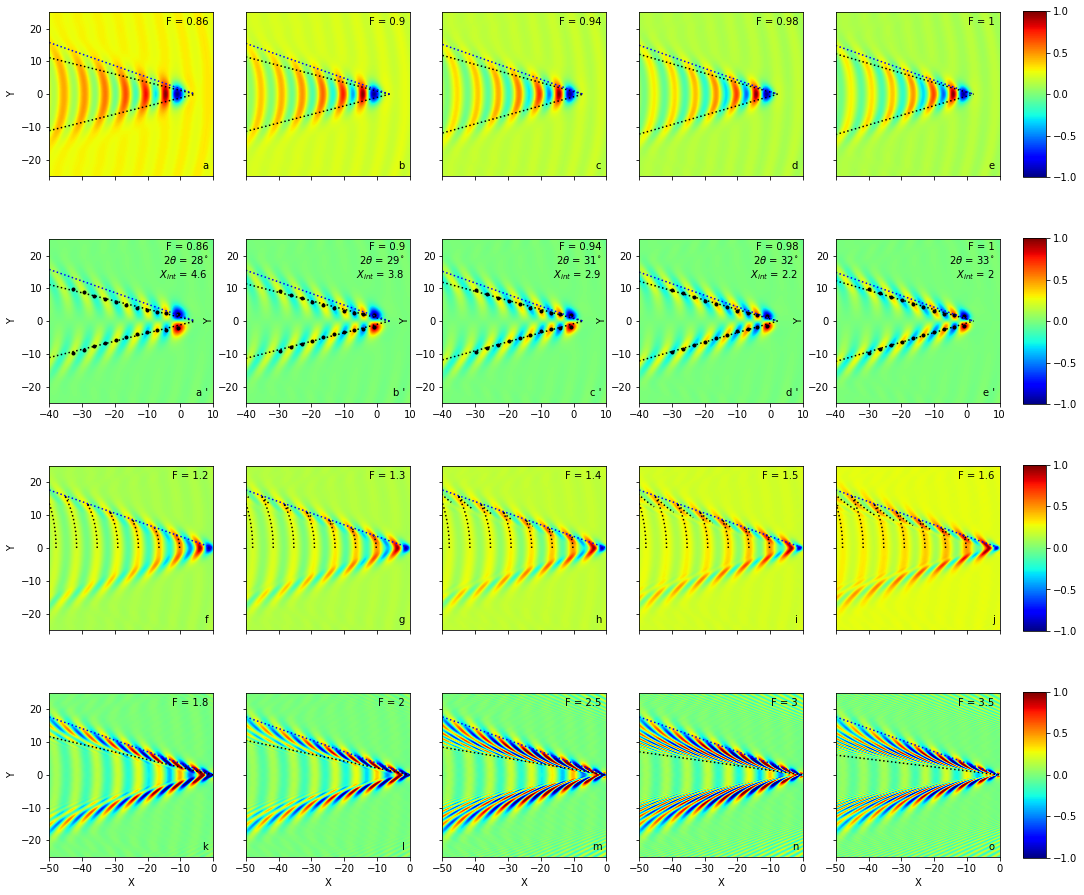

In [7]:
rows = np.array([[0.86, 0.90, 0.94, 0.98, 1.0],
                  [1.2, 1.3, 1.4, 1.5, 1.6],
                  [1.8, 2, 2.5, 3, 3.5]])
row2bs = np.array([8, 8, 5, 4, 4])
xbounds = [-50, 0]
ybounds = [-25, 25]
xbounds0 = [-40, 10]
ybounds0 = [-25, 25]
npy, npx = rows.shape

a = 1.4
fig = plt.figure(figsize=(16, 16))
axs, imgs = [None, None, None, None], [None, None, None, None]
label = 'a'

for j in range(npy):
    for i in range(npx):
        ind = i + 1 if j == 0 else (j+1) * npx + i + 1
        ax = fig.add_subplot(npy + 1, npx, ind)
        fr = rows[j, i]

        ax.set_xlim(xbounds)
        ax.set_ylim(ybounds)
        ax.text(0.97, 0.97, r'F = %g' % fr, transform=ax.transAxes, 
                    horizontalalignment='right', 
                    verticalalignment='top')
        ax.text(0.97, 0.03, label, transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='bottom')
        T = a * fr * fr
        xs = Xdict[fr]
        
        if j == 0:
            #Plot main image
            img = draw_wake_plot(ax, xs, Pdict[fr], scale=False)
            ax.set_xlim(xbounds0)
            ax.set_ylim(ybounds0)
            
            m, b, x_c, y_c = get_slope(xs, Pdict[fr], [xbounds0[0], 0], 10)
            twoT = 2 * np.arctan(-m) * 180 / np.pi
            print('F = %.2f\tSlope = %.3f\tX-int = %.3f\t2 Theta = %.3f Degrees' %
              (fr, m, -b/m, twoT))
            
            yp = m * xs + b
            xp = xs[yp >= 0]
            yp = yp[yp >= 0]
            ax.plot(xp, yp, 'k', linestyle=':')
            ax.plot(xp, -yp, 'k', linestyle=':')
            #Clear tick labels
            nlbls = len(ax.get_xticklabels())
            ax.set_xticklabels([''] * nlbls)
            draw_kelvin_angle(ax, xs, x0=[-b/m])
            
            
            #Plot gradient in y direction
            ax1 = fig.add_subplot(npy+1, npx, npx + i + 1)
            ax1.set_xlim(xbounds0)
            ax1.set_ylim(ybounds0)
            ax1.set_ylabel('Y')
            ax1.text(0.97, 0.97, 'F = %g\n$2\\theta$ = %.2g$^{\\circ}$\n$X_{int}$ = %.2g' % (fr, twoT, -b/m), 
                     transform=ax1.transAxes, 
                     horizontalalignment='right', 
                     verticalalignment='top')
            ax1.text(0.97, 0.03, label+' \'', transform=ax1.transAxes,
                     horizontalalignment='right',
                     verticalalignment='bottom')
            py, px = np.gradient(Pdict[fr])
            img1 = draw_wake_plot(ax1, xs, py, scale=False)
            ax1.plot(xp, yp, 'k', linestyle=':')
            ax1.plot(xp, -yp, 'k', linestyle=':')
            ax1.plot(x_c, y_c, 'ko', markersize=3)
            draw_kelvin_angle(ax1, xs, x0=[-b/m])
            axs[j+1] = ax1
            imgs[j+1] = img1
        elif j == 1:
            img = draw_wake_plot(ax, xs, Pdict[fr], scale=False)
            t = np.linspace(1, T, 10000)
            draw_parametric_wake(ax, 8, t, color='black')
            draw_kelvin_angle(ax, xs)
            #Clear tick labels
            nlbls = len(ax.get_xticklabels())
            ax.set_xticklabels([''] * nlbls)
        elif j == 2:
            img = draw_wake_plot(ax, xs, Pdict[fr], bound=row2bs[i], scale=True)
            draw_kelvin_angle(ax, xs)
            draw_inner_angle(ax, xs, T, color='black')
            ax.set_xlabel('X')

        if i == 0:
            ax.set_ylabel('Y')
        else:
            #Clear tick labels
            nlbls = len(ax.get_yticklabels())
            ax.set_yticklabels([''] * nlbls)
        axs[j if j == 0 else j + 1] = ax
        imgs[j if j == 0 else j + 1] = img
        label = chr(ord(label) + 1)

#Add colorbars
fig.subplots_adjust(right=0.95)
for j in range(npy+1):
    bb = axs[j].get_position().bounds
    cbar_ax = fig.add_axes([0.97, bb[1]+0.01, 0.02, bb[3]-0.02])
    fig.colorbar(imgs[j], cax=cbar_ax, ticks=[-1, -0.5, 0, 0.5, 1.0])

plt.show()